In [18]:
import os
import torch

# Импорт модели
from Model import SiameseViT

# Импорт функций подготовки данных
from Data_process import Data_Transform

# Импорт цикла обучения и валидации 
from Trainer import train_model, evaluate_model

# Импорт функций визуализации
from Visual_func import plot_training_history, plot_confusion_matrix, visualize_pair

# Импорт функции потерь и функций расчета метрик
from Loss_Metrics import AdaptiveContrastiveLoss, calculate_metrics, create_confusion_matrix



# Проверка наличия GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Устройство: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Всего GPU памяти: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Устройство: cuda
GPU: NVIDIA GeForce RTX 3090
Всего GPU памяти: 25.29 GB


## Подготовка данных
### Путь к данным

In [2]:
Data_PATH = r"/home/Doctor_S/PYTHON_PROJECTS/STUDY/Signature/Data"

### Обработка путей

In [3]:
Images_path = os.path.join(Data_PATH, "full")
Data_csv_path = os.path.join(Data_PATH, "data.csv")
Test_data_path = os.path.join(Data_PATH, "test_data.csv")
Train_data_path = os.path.join(Data_PATH, "train_data.csv")

print(f"Корневая директория: {Data_PATH}")
print(f"Изображения: {Images_path}")
print(f"Train CSV: {Train_data_path}")
print(f"Test CSV: {Test_data_path}")

Корневая директория: /home/Doctor_S/PYTHON_PROJECTS/STUDY/Signature/Data
Изображения: /home/Doctor_S/PYTHON_PROJECTS/STUDY/Signature/Data/full
Train CSV: /home/Doctor_S/PYTHON_PROJECTS/STUDY/Signature/Data/train_data.csv
Test CSV: /home/Doctor_S/PYTHON_PROJECTS/STUDY/Signature/Data/test_data.csv


## Создание обучающих и валидационных данных
### Параметры данных

In [4]:
BATCH_SIZE = 512
BATCH_SIZE_VAL = 256

image_size = (128, 256)

### Создаем и загружаем датасеты

CUDA in dataloaders: True 

Количество образцов в датасете: 76721
Количество образцов в датасете: 8525

Успешно загружены датасеты:
Train samples: 76721
Test samples: 8525

Визуализация примера из датасета TRAIN


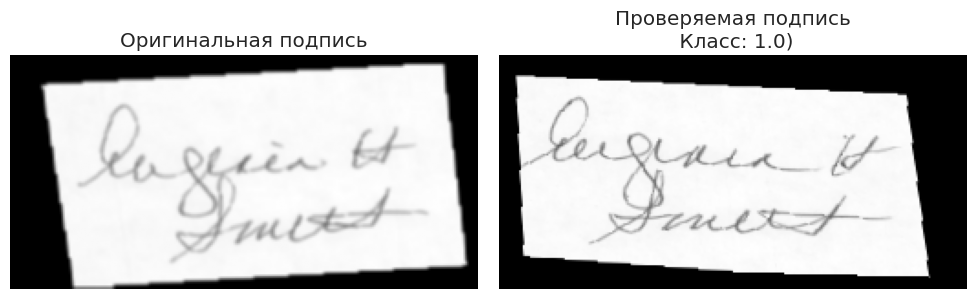

Визуализация примера из датасета TEST


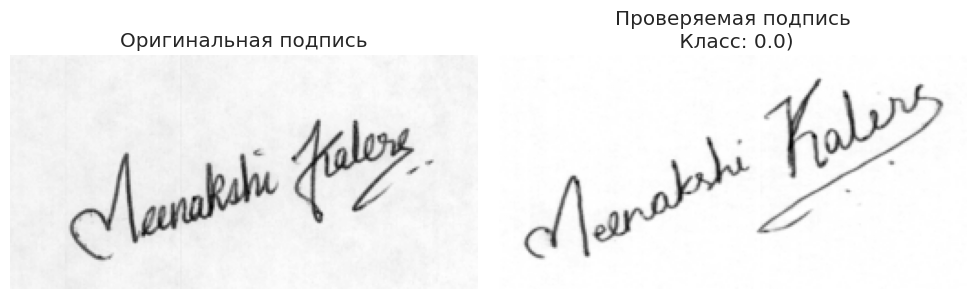

In [21]:
data_transformer = Data_Transform(Train_data_path, Test_data_path, Images_path, image_size = image_size)
train_ds, _ = data_transformer.create_datasets(vizual_id=0)

### Пример обучающих данных

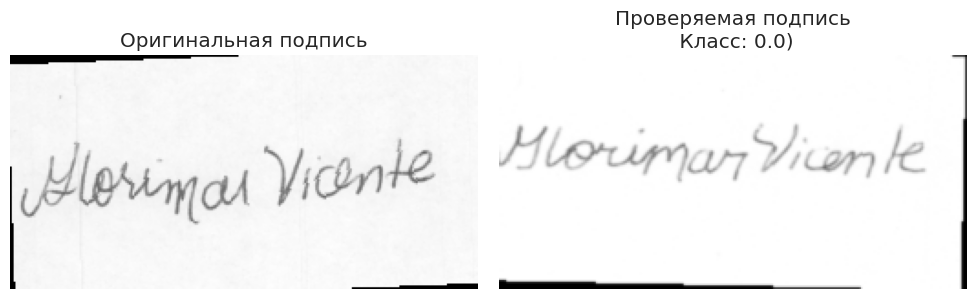

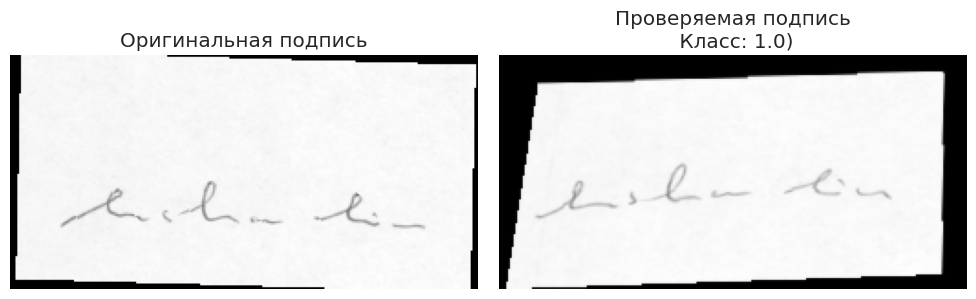

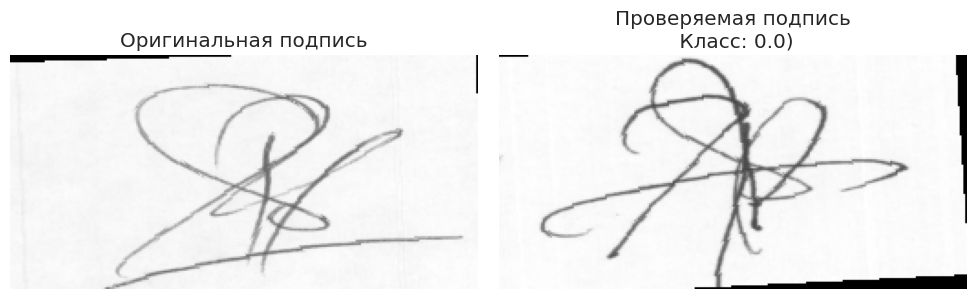

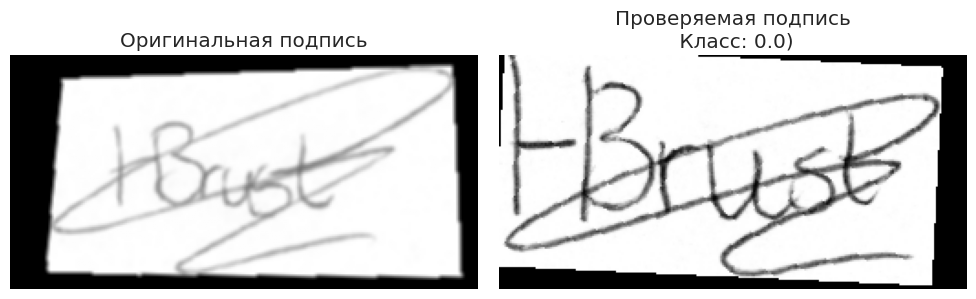

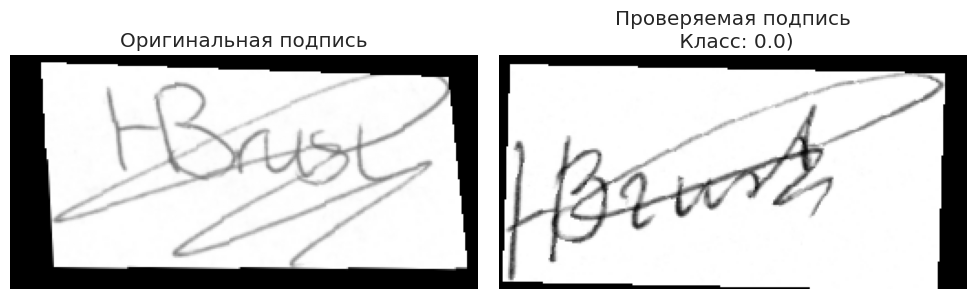

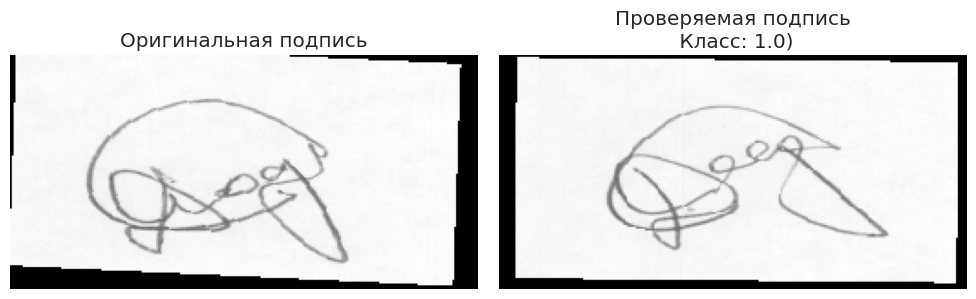

In [22]:
for i in range(10, 16):
    visualize_pair(train_ds, i)

### Создаем даталоадеры

In [6]:
train_loader, test_loader = data_transformer.create_dataloaders(BATCH_SIZE, BATCH_SIZE_VAL)

DataLoaders:
Train batches: 150
Test batches: 34


## Создание модели

In [7]:
# Инициализация модели
model_params = {
    "feature_dim": 1024,
    "embed_dim": 256,
    "img_size": image_size
}

model = SiameseViT(**model_params).to(device)
print(f"Общее количество параметров модели: {sum(p.numel() for p in model.parameters()):,}")

Общее количество параметров модели: 13,409,985


## Инициализация параметров обучения

In [8]:
# Количнство эпох
warmup_epochs = 3
total_epochs = 20

# Пути сохранения моделей
best_model_path = 'best_model.pth'
final_model_path = 'final_model.pth'


# Оптимизатор с разделением весов
backbone_params = list(model.feature_extractor.parameters())
head_params = list(model.asymmetric_comparator.parameters())

optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 1e-4},
    {'params': head_params, 'lr': 3e-4}
], weight_decay=1e-4)

# Планировщики обучения
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.1, total_iters=warmup_epochs
)
main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=total_epochs - warmup_epochs, eta_min=1e-6
)

# Функция потерь
criterion = AdaptiveContrastiveLoss(margin=0.5, alpha=0.8)

## Обучние модели

Начало обучения модели на 20 эпохах


Эпоха 1/20 [Train]:   0%|          | 0/150 [00:00<?, ?it/s]

Train Loss: 0.3083 | Val Loss: 0.1109
Train F1: 0.8215 | Val F1: 0.9417
Val Precision: 0.8960 | Recall: 0.9923
Learning Rate: 0.000040
Новая лучшая модель сохранена! F1: 0.9417


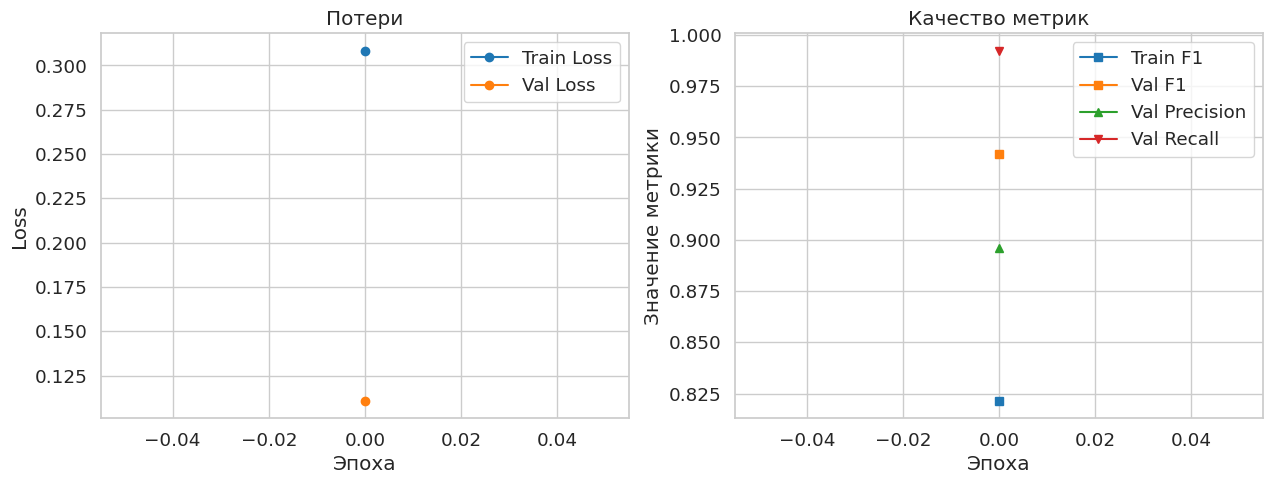

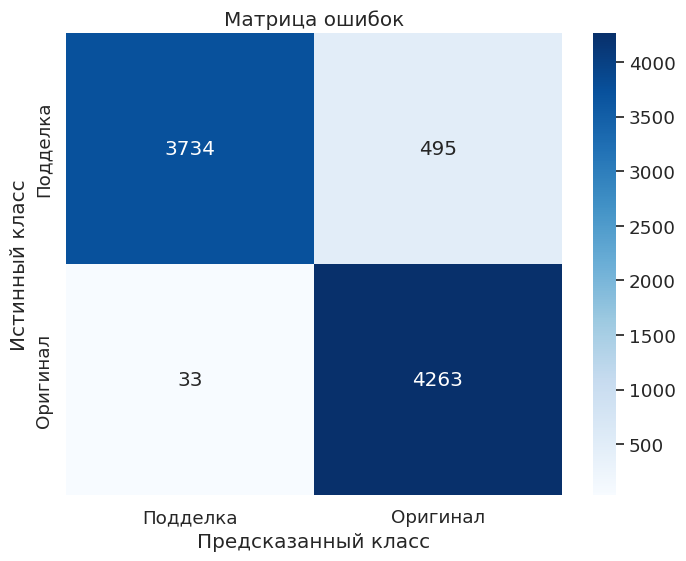

Train Loss: 0.1850 | Val Loss: 0.1048
Train F1: 0.9014 | Val F1: 0.9492
Val Precision: 0.9354 | Recall: 0.9635
Learning Rate: 0.000070
Новая лучшая модель сохранена! F1: 0.9492


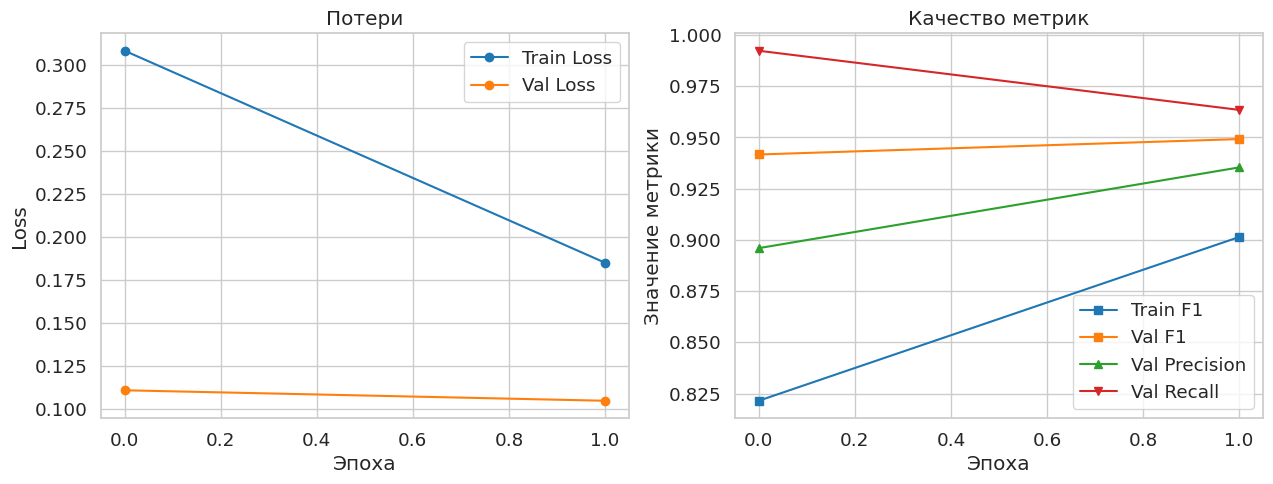

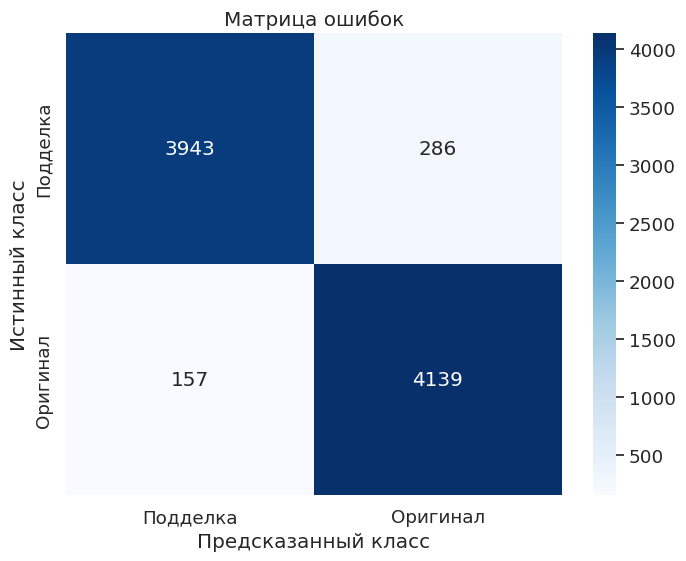

Train Loss: 0.1925 | Val Loss: 0.0962
Train F1: 0.8991 | Val F1: 0.9541
Val Precision: 0.9481 | Recall: 0.9602
Learning Rate: 0.000100
Новая лучшая модель сохранена! F1: 0.9541


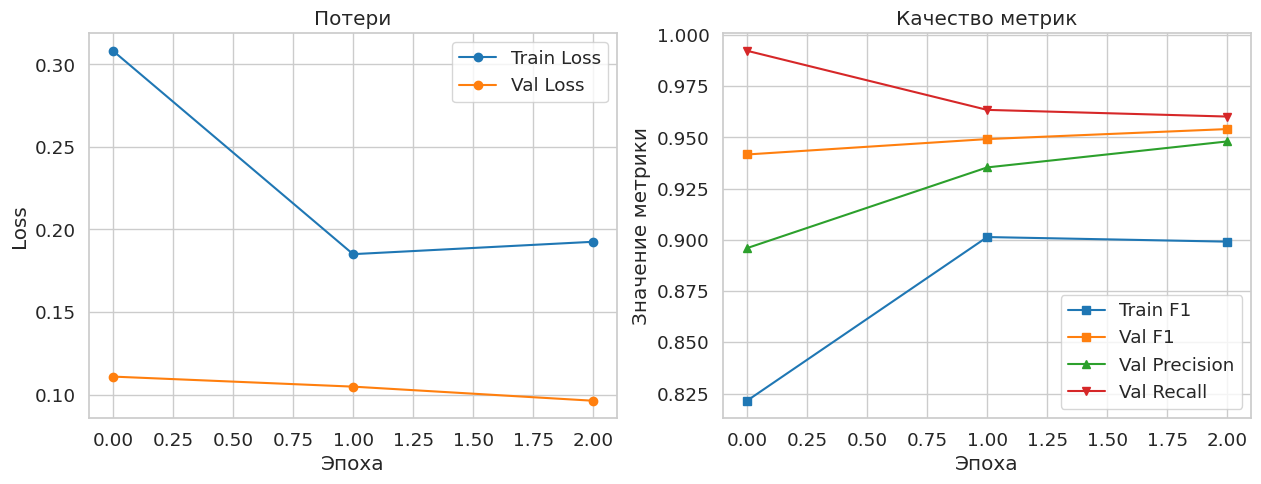

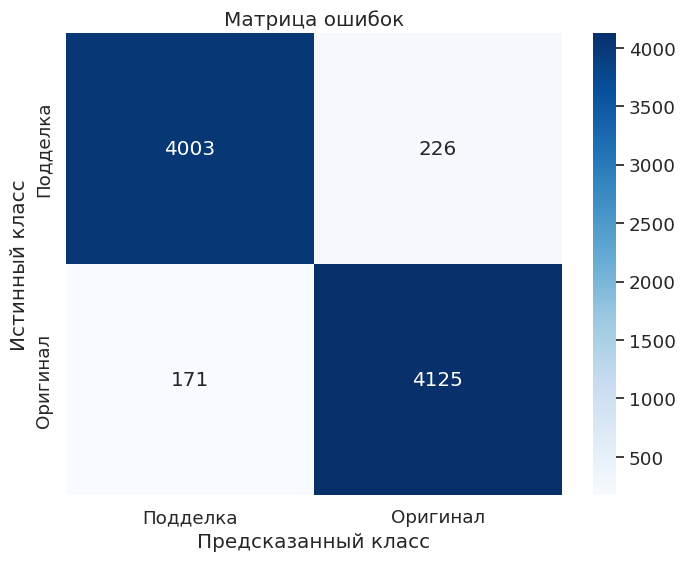

Train Loss: 0.1908 | Val Loss: 0.0893
Train F1: 0.9025 | Val F1: 0.9537
Val Precision: 0.9238 | Recall: 0.9856
Learning Rate: 0.000099


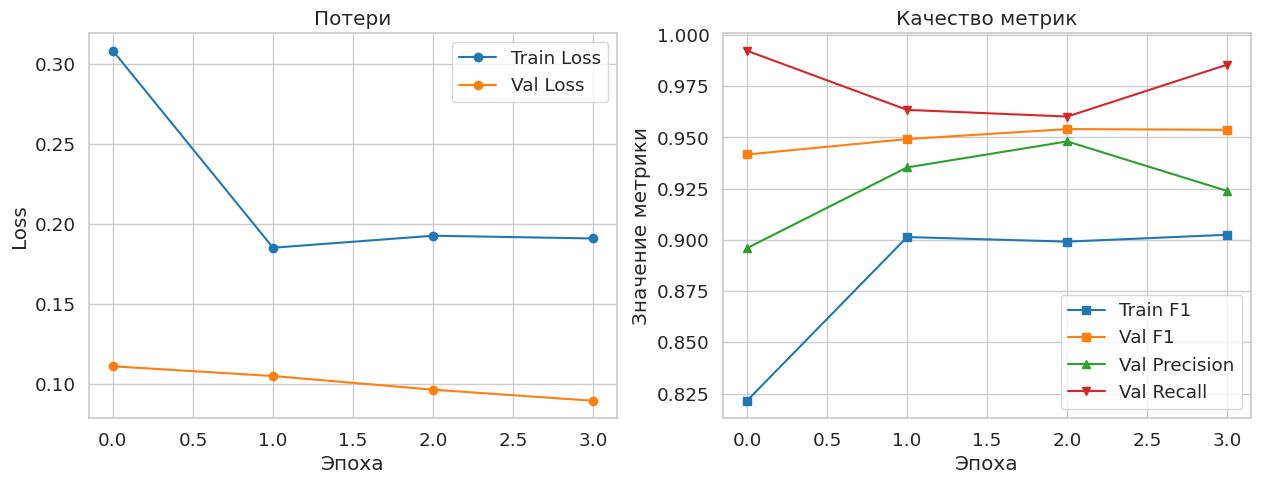

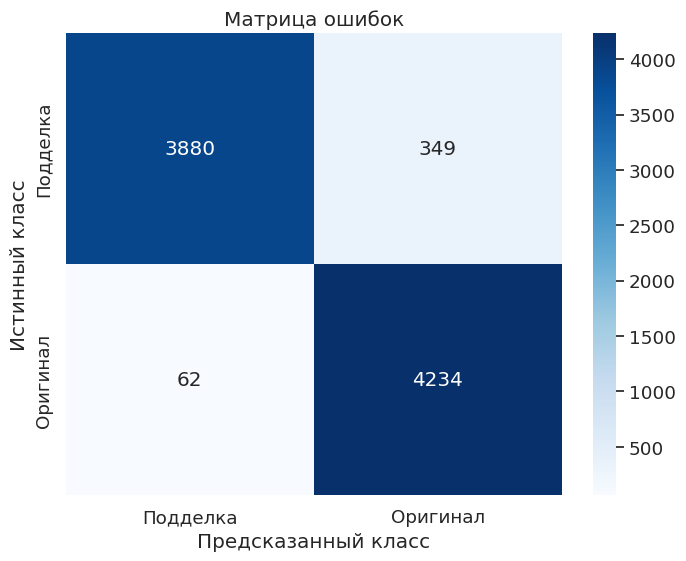

Train Loss: 0.1475 | Val Loss: 0.1125
Train F1: 0.9225 | Val F1: 0.9393
Val Precision: 0.9793 | Recall: 0.9025
Learning Rate: 0.000097


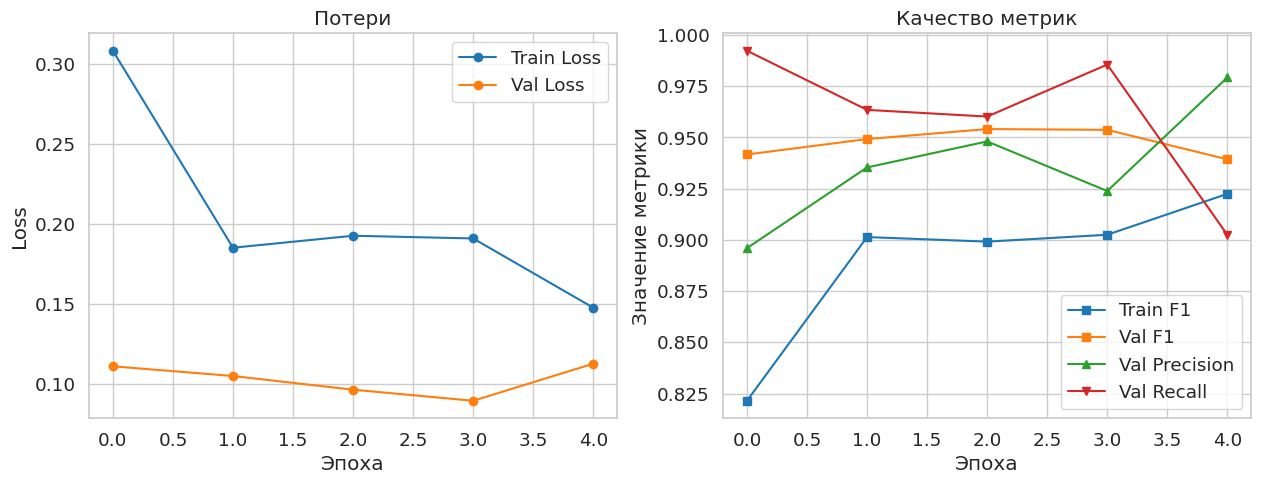

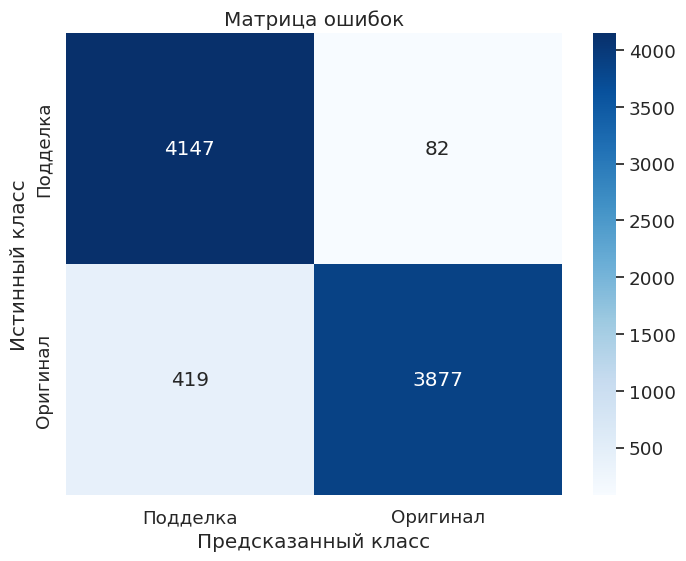

Train Loss: 0.1271 | Val Loss: 0.0985
Train F1: 0.9335 | Val F1: 0.9421
Val Precision: 0.9872 | Recall: 0.9008
Learning Rate: 0.000093


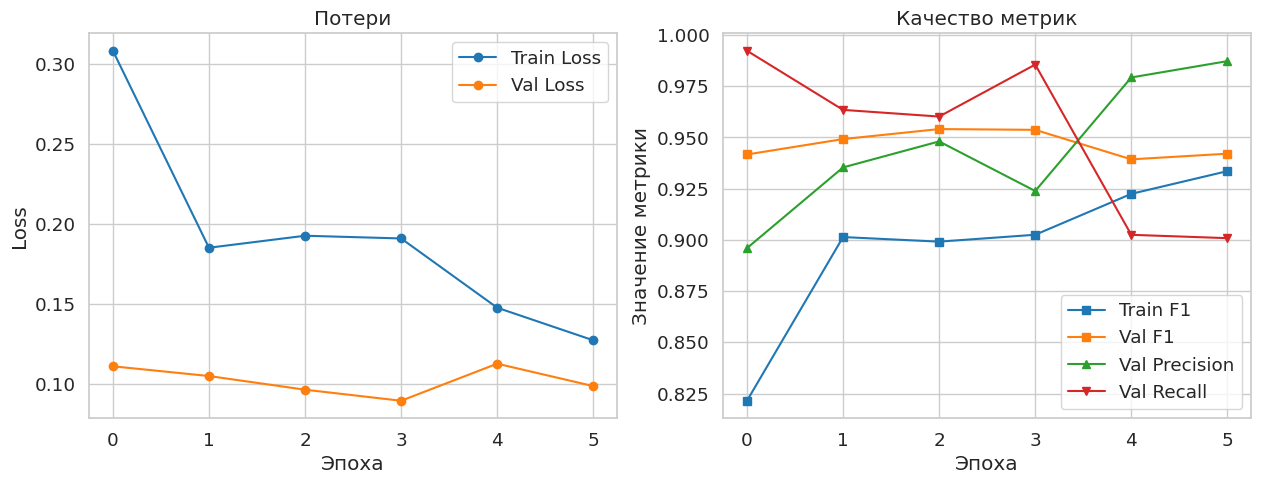

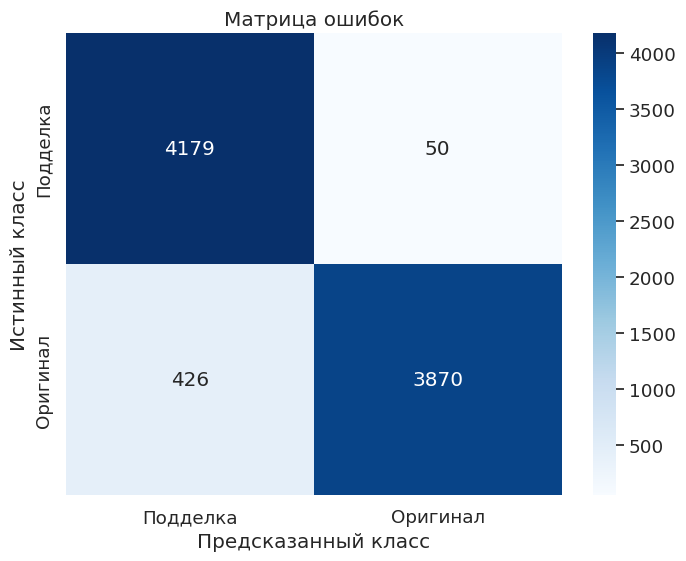

Train Loss: 0.1172 | Val Loss: 0.0779
Train F1: 0.9376 | Val F1: 0.9674
Val Precision: 0.9743 | Recall: 0.9607
Learning Rate: 0.000087
Новая лучшая модель сохранена! F1: 0.9674


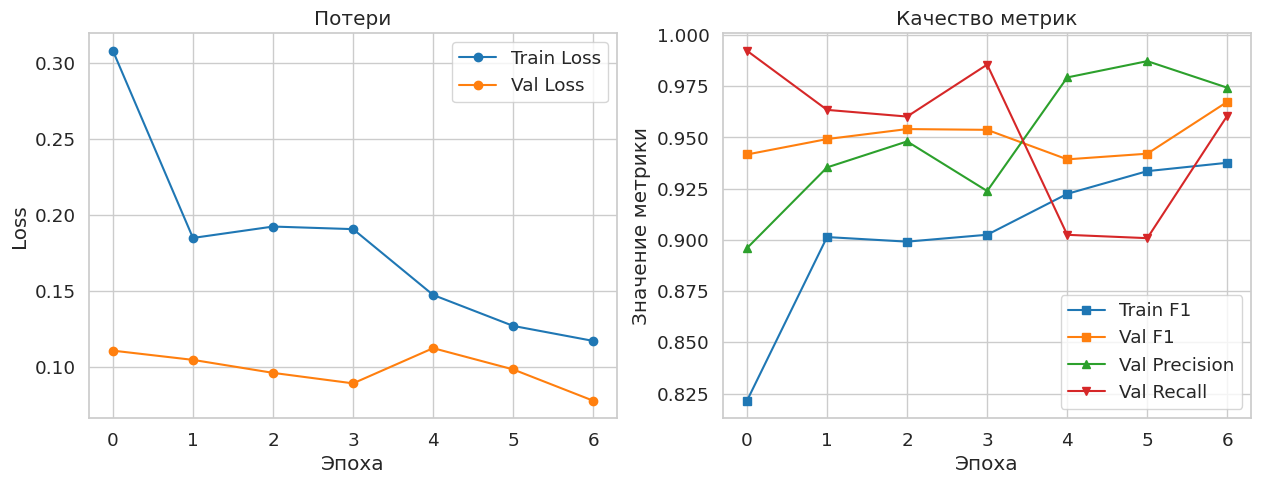

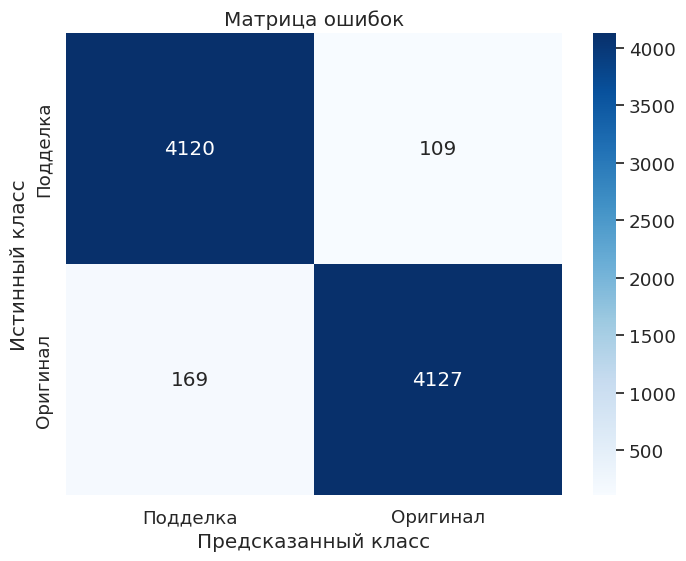

Train Loss: 0.1032 | Val Loss: 0.0836
Train F1: 0.9454 | Val F1: 0.9583
Val Precision: 0.9867 | Recall: 0.9316
Learning Rate: 0.000080


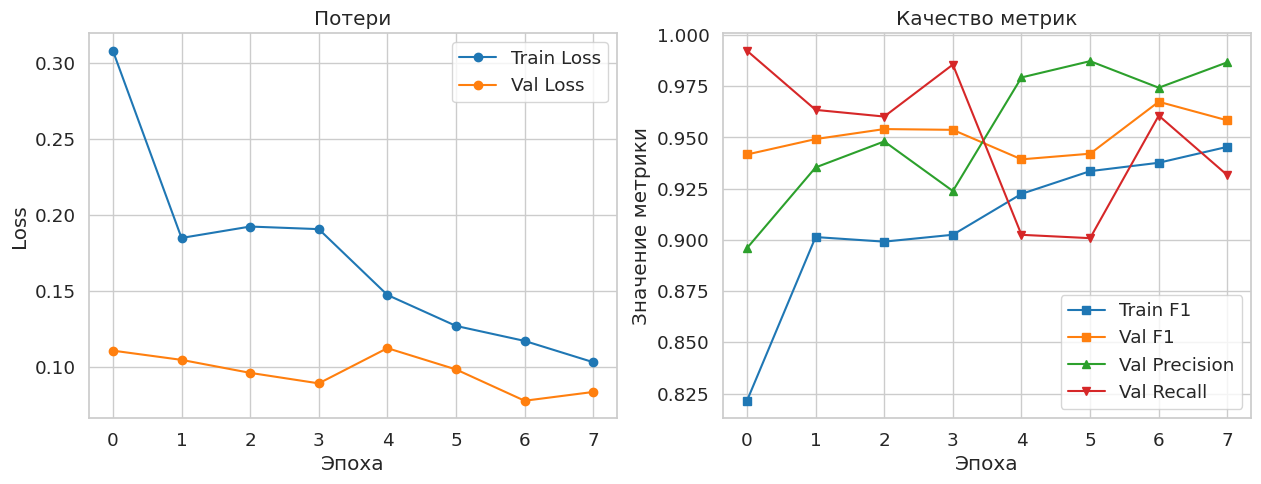

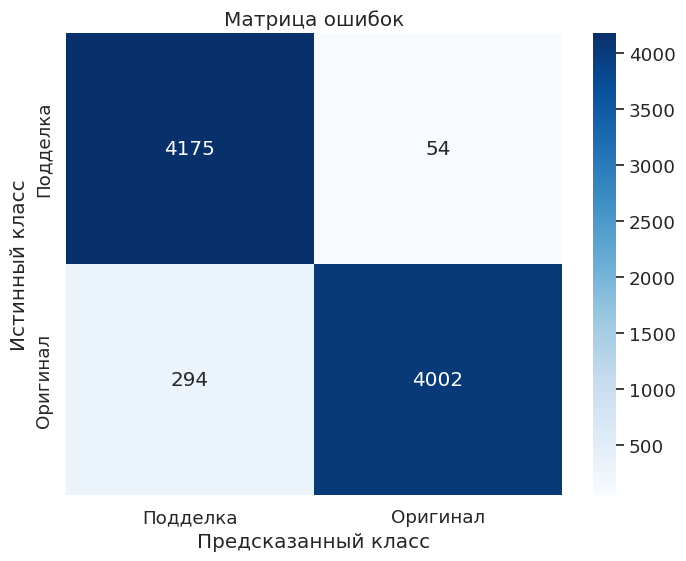

Train Loss: 0.0951 | Val Loss: 0.0615
Train F1: 0.9500 | Val F1: 0.9740
Val Precision: 0.9802 | Recall: 0.9679
Learning Rate: 0.000073
Новая лучшая модель сохранена! F1: 0.9740


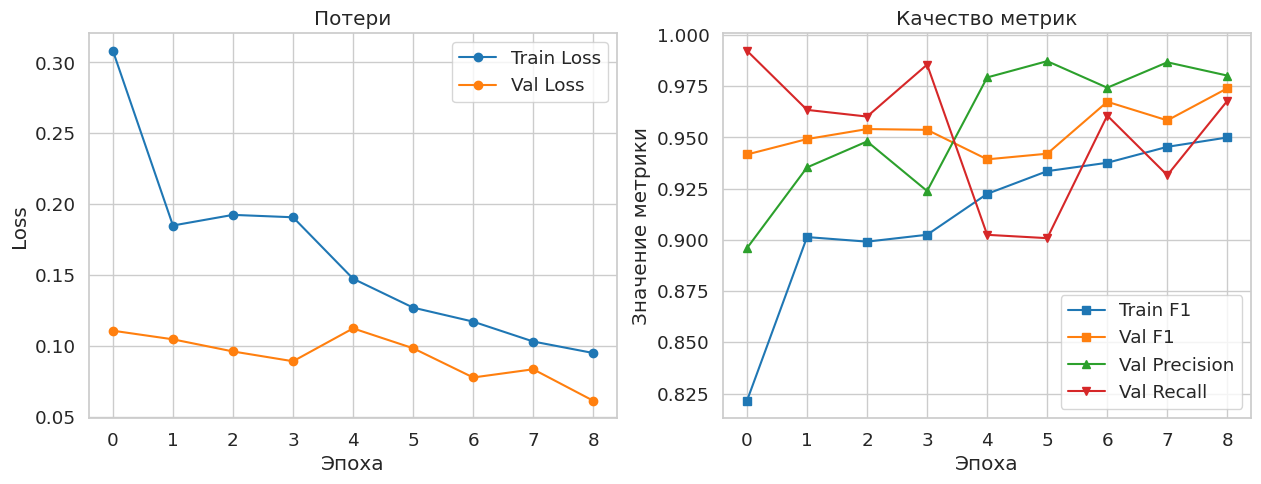

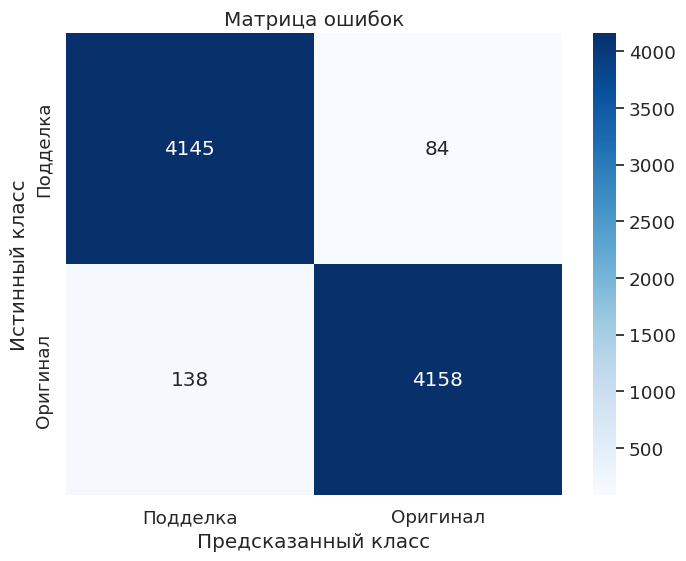

Train Loss: 0.0929 | Val Loss: 0.0854
Train F1: 0.9521 | Val F1: 0.9556
Val Precision: 0.9925 | Recall: 0.9213
Learning Rate: 0.000064


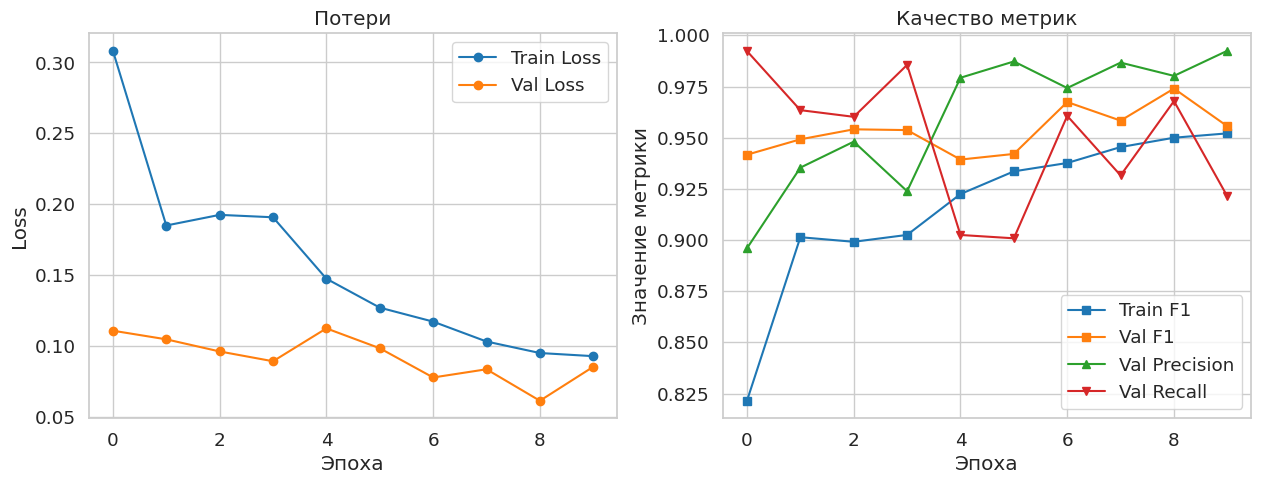

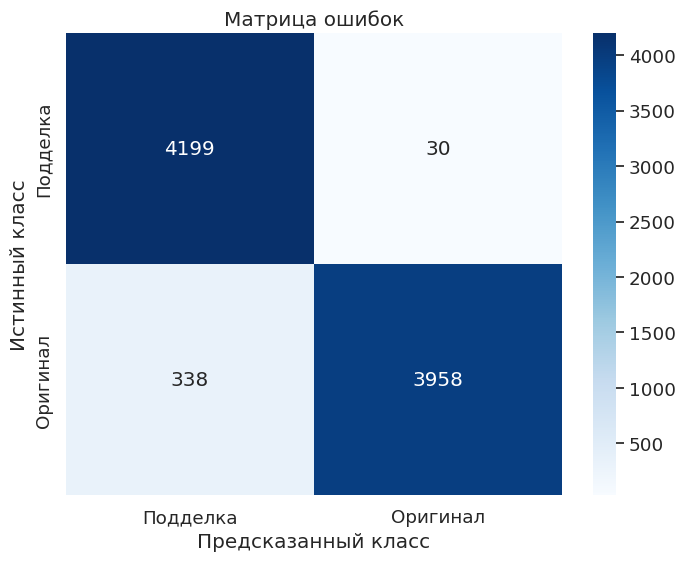

Train Loss: 0.0891 | Val Loss: 0.0567
Train F1: 0.9546 | Val F1: 0.9705
Val Precision: 0.9515 | Recall: 0.9902
Learning Rate: 0.000055


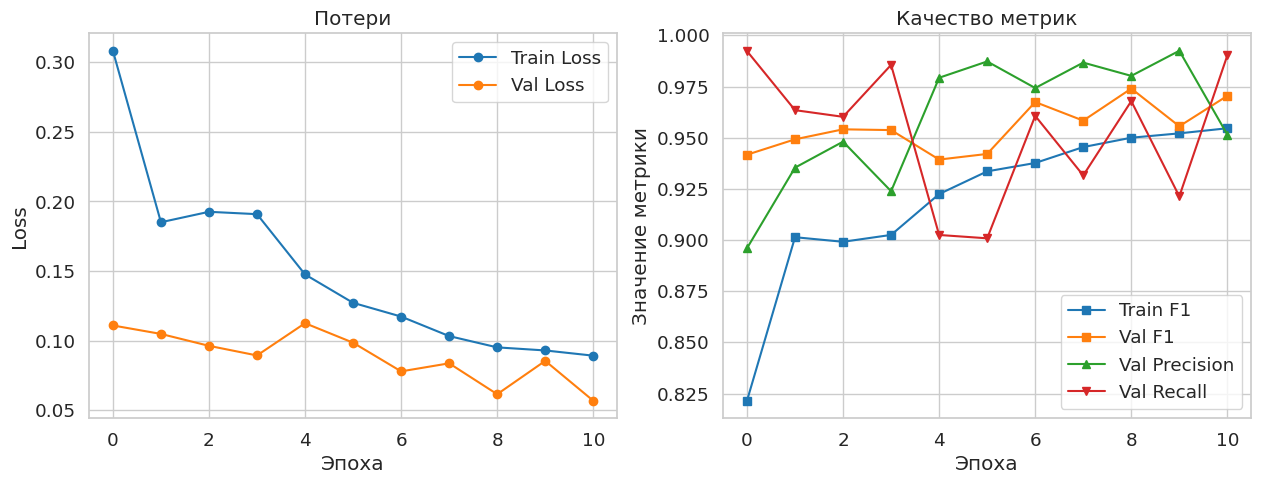

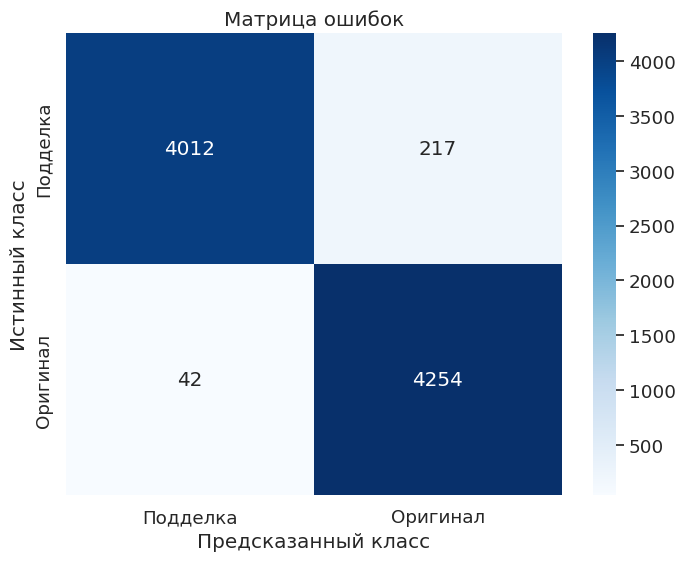

Train Loss: 0.0808 | Val Loss: 0.0452
Train F1: 0.9586 | Val F1: 0.9788
Val Precision: 0.9744 | Recall: 0.9832
Learning Rate: 0.000046
Новая лучшая модель сохранена! F1: 0.9788


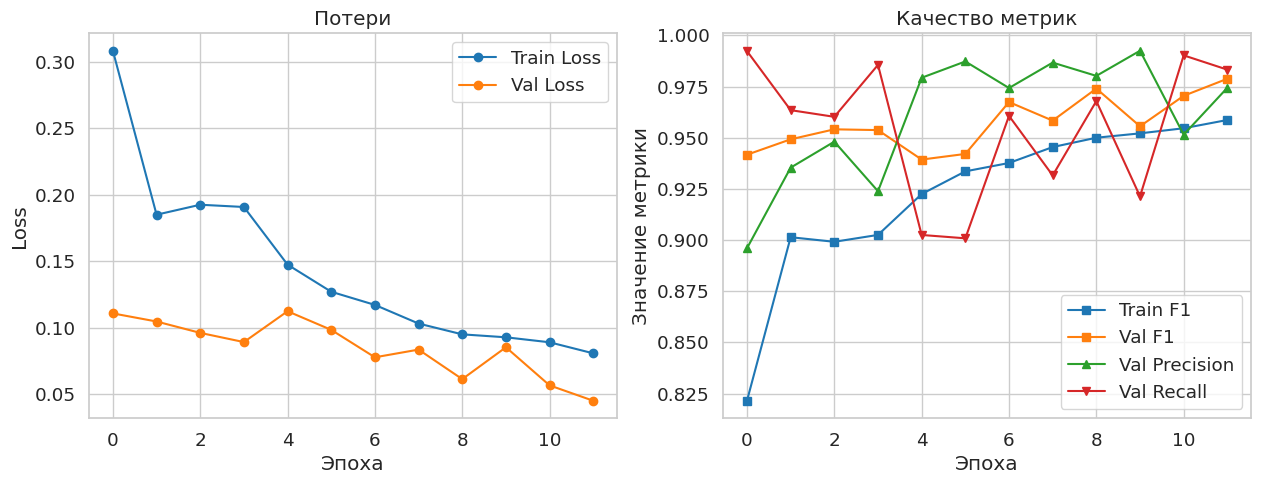

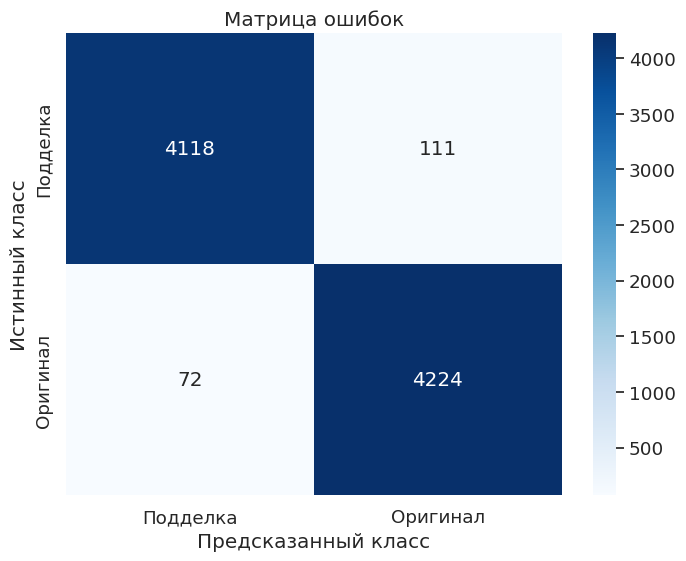

Train Loss: 0.0756 | Val Loss: 0.0453
Train F1: 0.9615 | Val F1: 0.9776
Val Precision: 0.9741 | Recall: 0.9811
Learning Rate: 0.000037


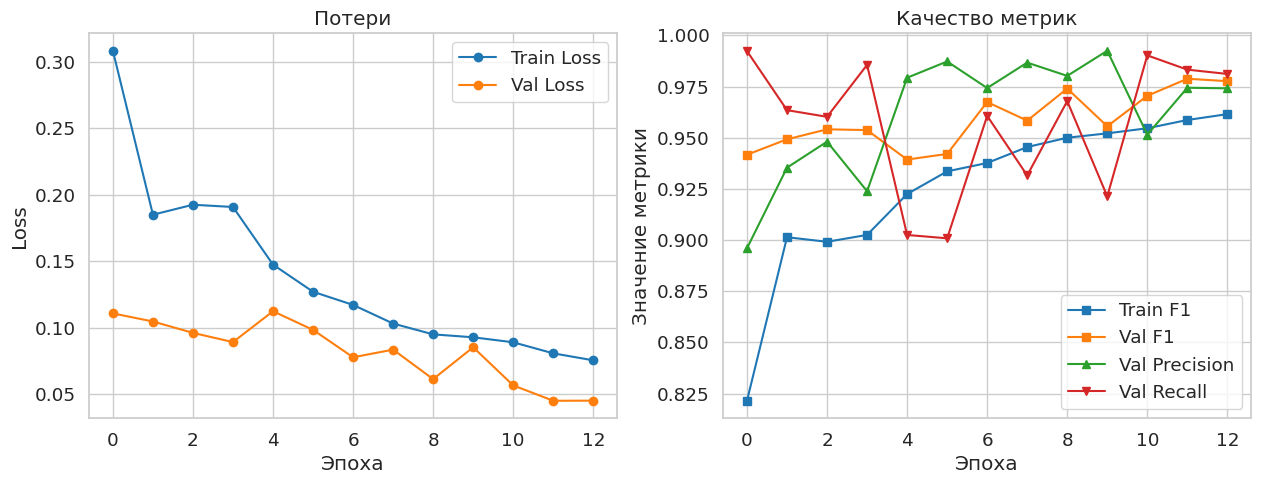

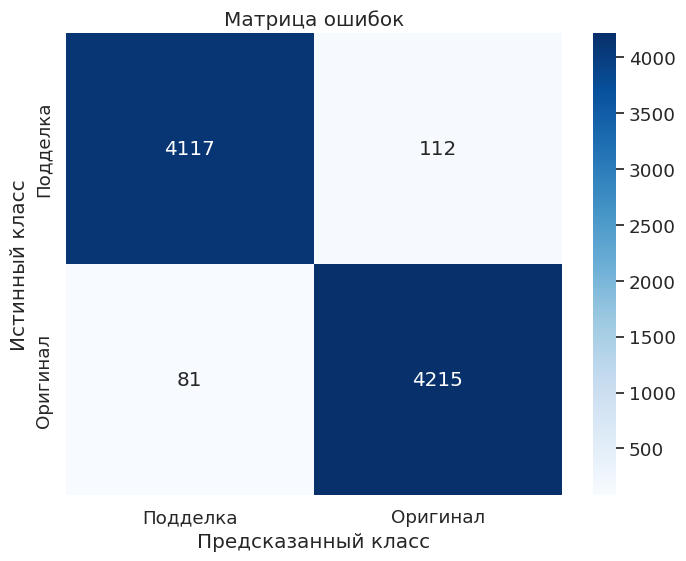

Train Loss: 0.0659 | Val Loss: 0.0398
Train F1: 0.9666 | Val F1: 0.9815
Val Precision: 0.9752 | Recall: 0.9879
Learning Rate: 0.000028
Новая лучшая модель сохранена! F1: 0.9815


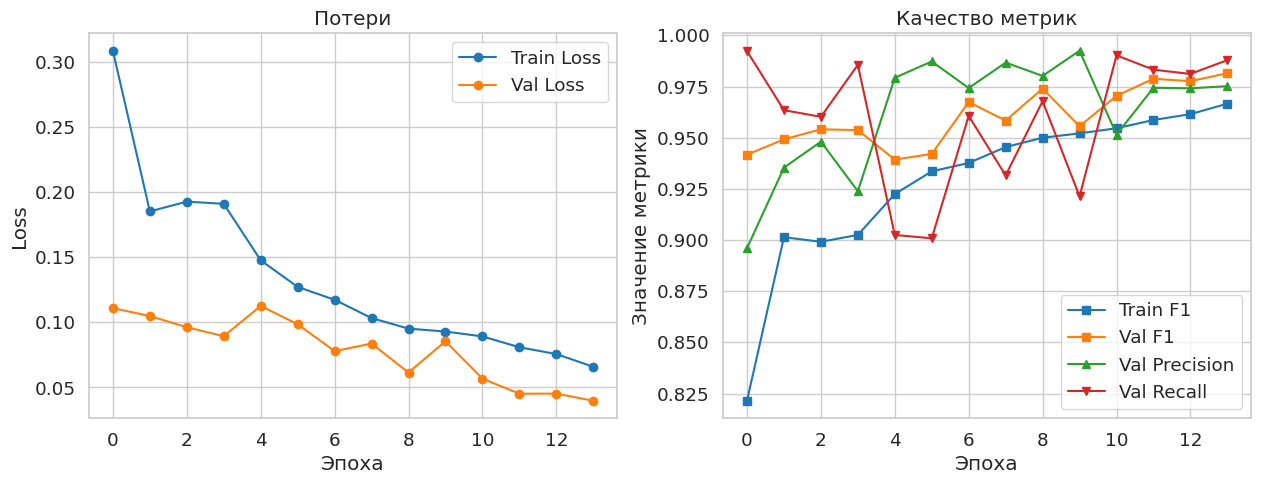

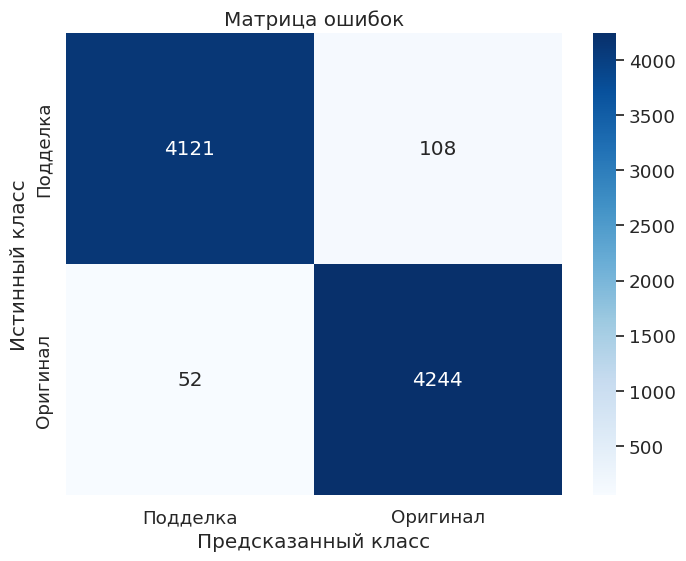

Train Loss: 0.0652 | Val Loss: 0.0351
Train F1: 0.9670 | Val F1: 0.9836
Val Precision: 0.9781 | Recall: 0.9891
Learning Rate: 0.000021
Новая лучшая модель сохранена! F1: 0.9836


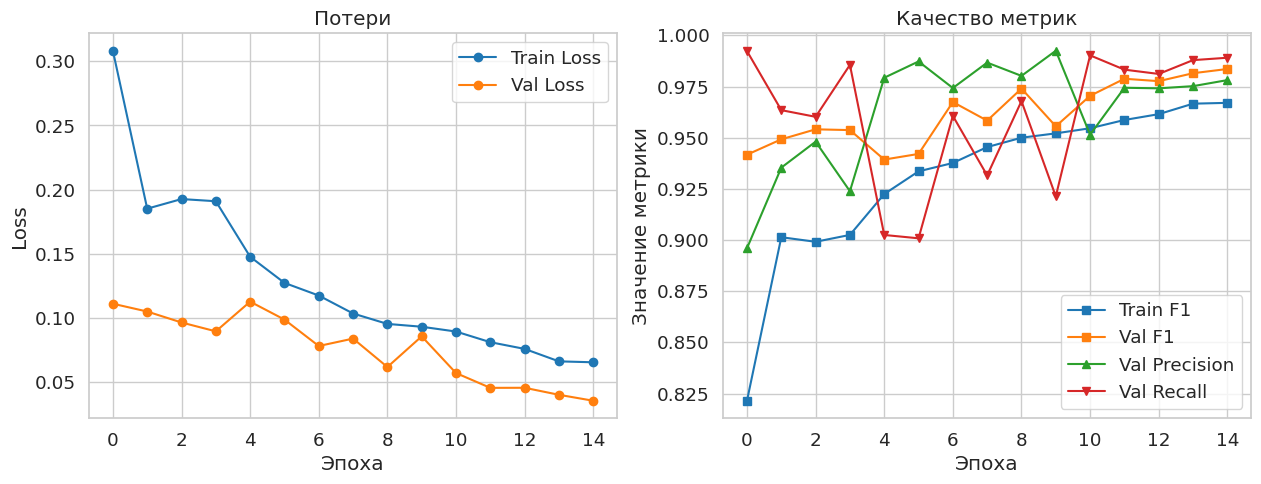

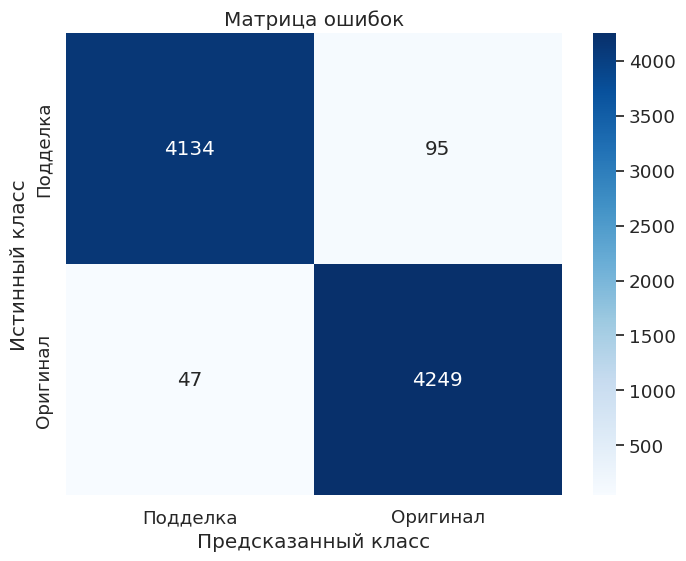

Train Loss: 0.0619 | Val Loss: 0.0335
Train F1: 0.9689 | Val F1: 0.9840
Val Precision: 0.9830 | Recall: 0.9849
Learning Rate: 0.000014
Новая лучшая модель сохранена! F1: 0.9840


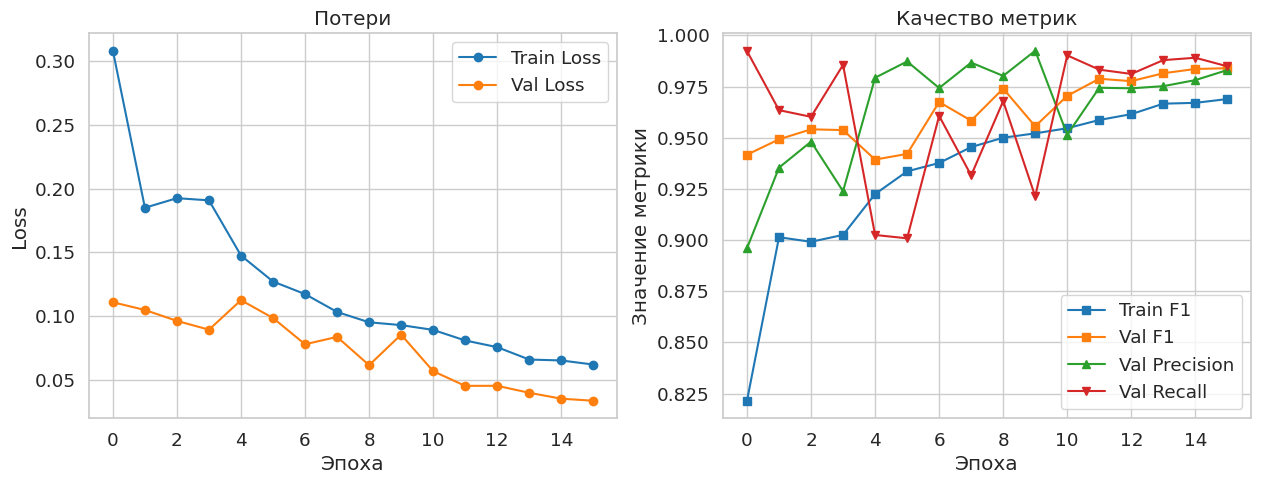

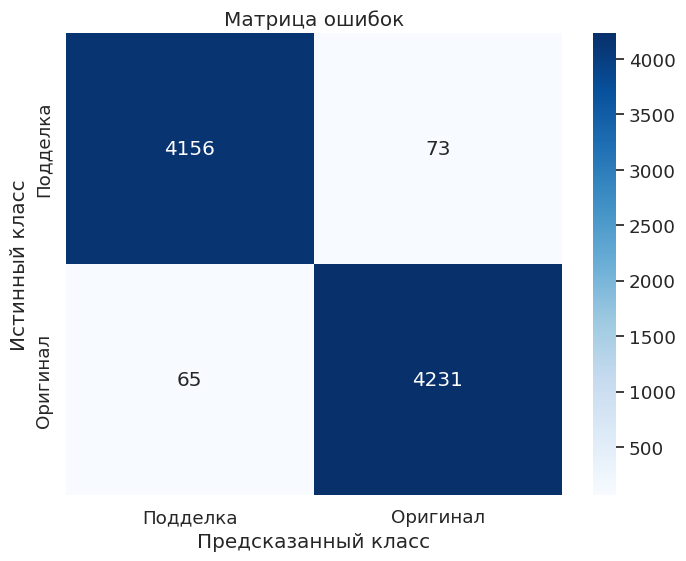

Train Loss: 0.0582 | Val Loss: 0.0349
Train F1: 0.9705 | Val F1: 0.9848
Val Precision: 0.9865 | Recall: 0.9832
Learning Rate: 0.000008
Новая лучшая модель сохранена! F1: 0.9848


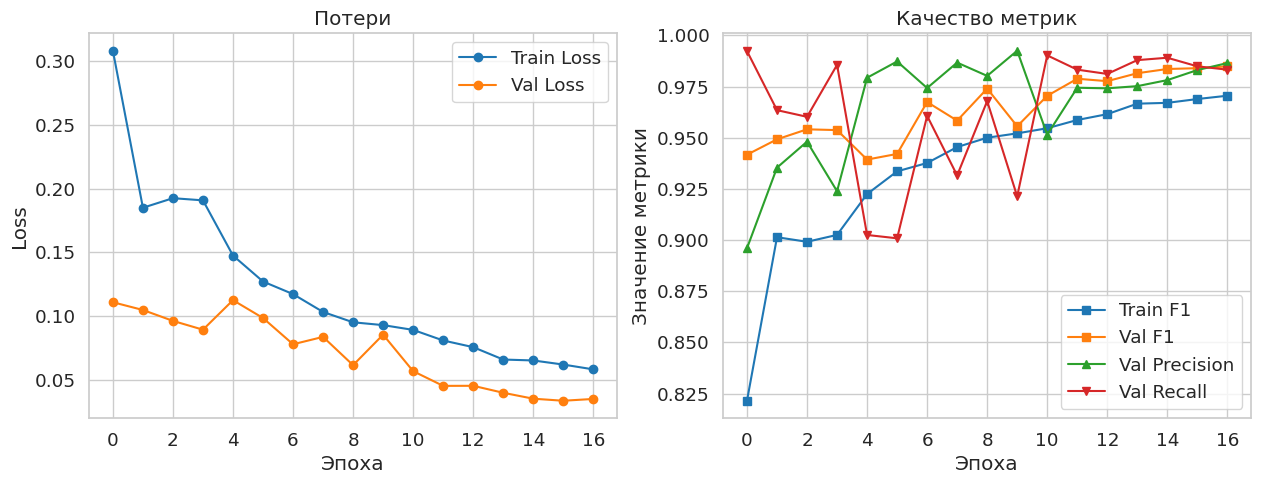

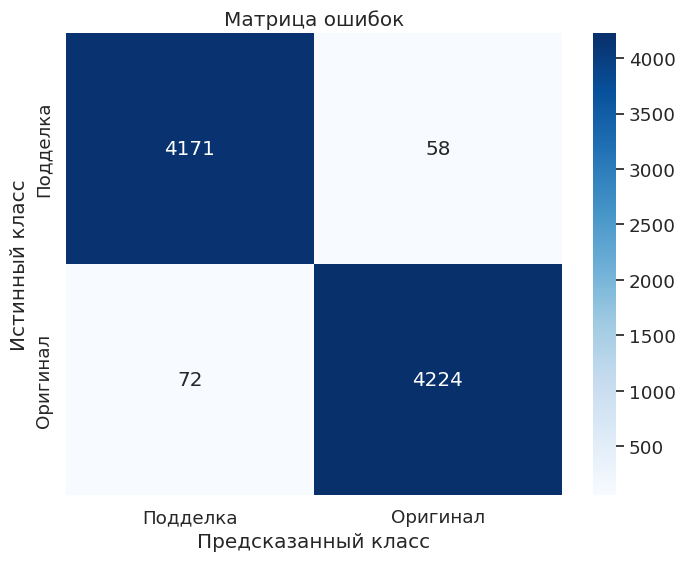

Train Loss: 0.0560 | Val Loss: 0.0318
Train F1: 0.9719 | Val F1: 0.9857
Val Precision: 0.9827 | Recall: 0.9888
Learning Rate: 0.000004
Новая лучшая модель сохранена! F1: 0.9857


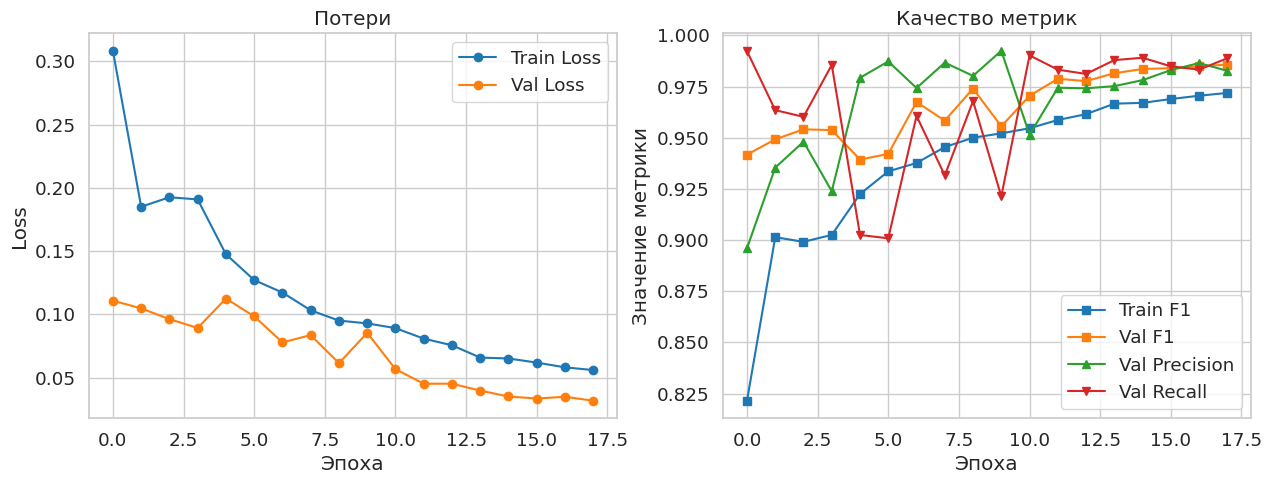

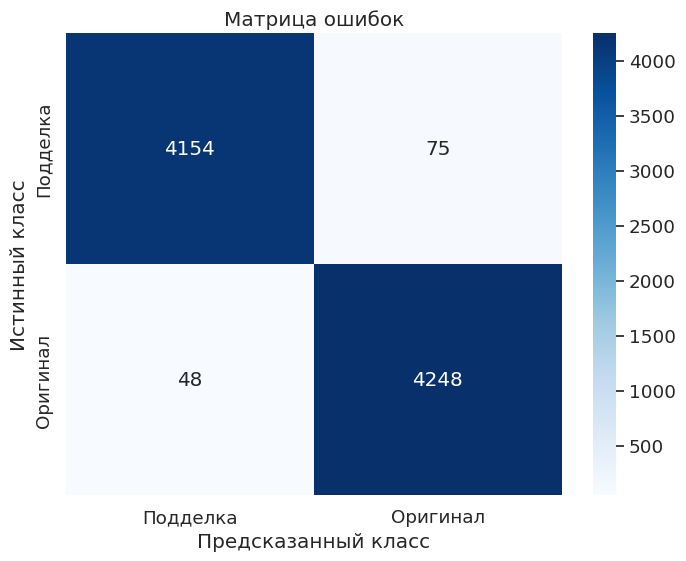

Train Loss: 0.0542 | Val Loss: 0.0290
Train F1: 0.9726 | Val F1: 0.9878
Val Precision: 0.9863 | Recall: 0.9893
Learning Rate: 0.000002
Новая лучшая модель сохранена! F1: 0.9878


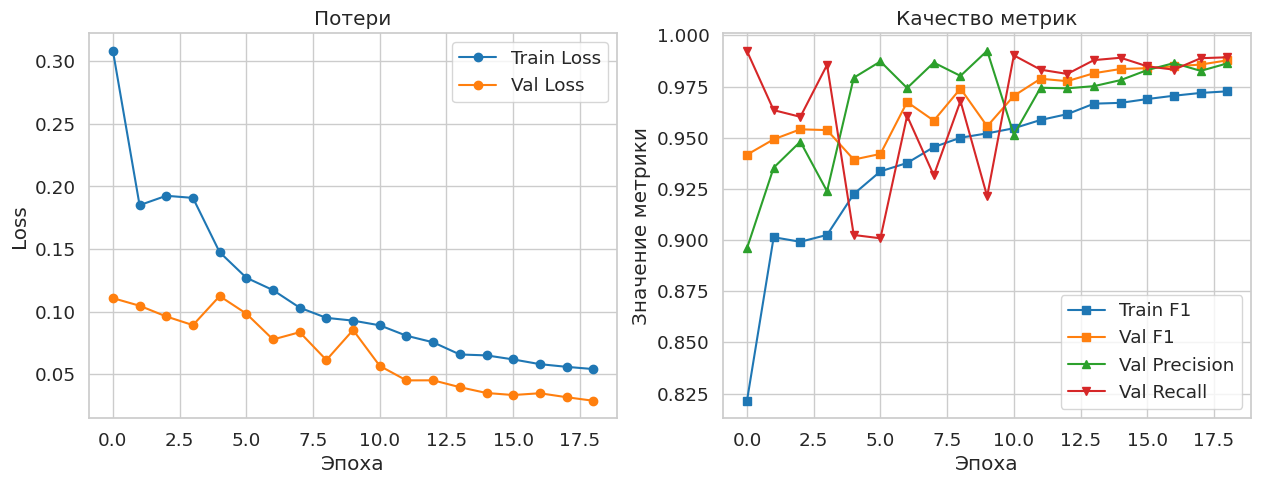

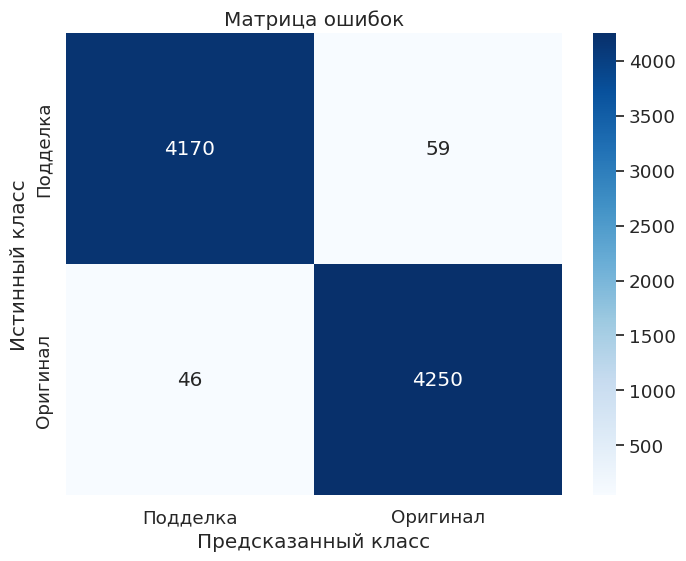

Train Loss: 0.0521 | Val Loss: 0.0300
Train F1: 0.9739 | Val F1: 0.9870
Val Precision: 0.9874 | Recall: 0.9865
Learning Rate: 0.000001


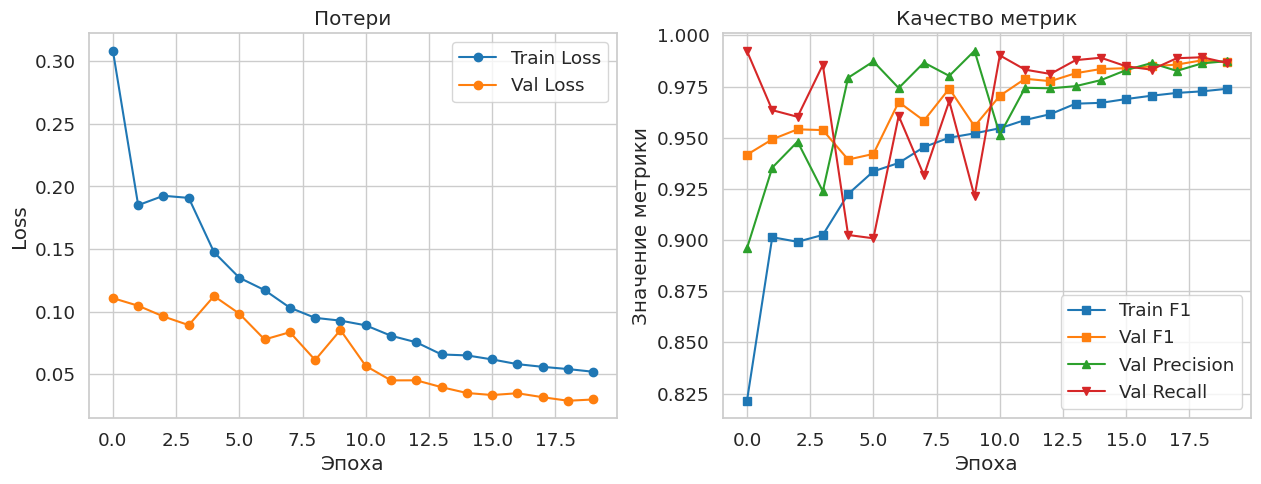

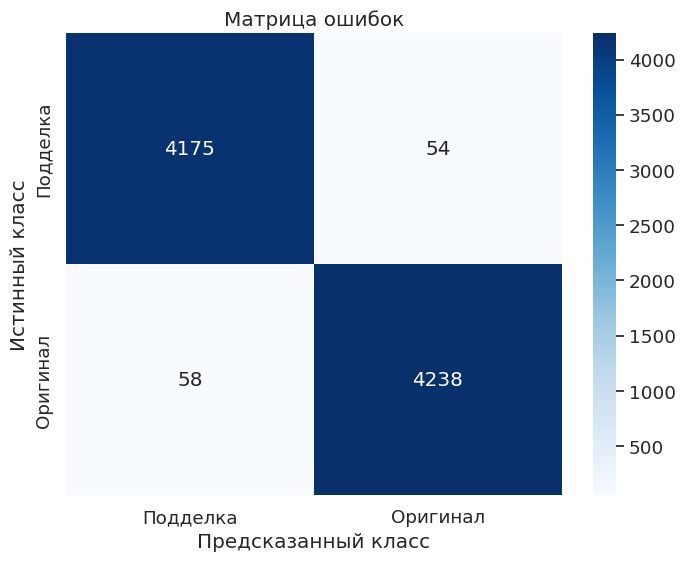

ОБУЧЕНИЕ ЗАВЕРШЕНО
Лучший F1-скор: 0.9878 на эпохе 19


In [9]:
trained_model, history = train_model( model, total_epochs, train_loader, test_loader,
                            warmup_scheduler, main_scheduler, warmup_epochs,
                            optimizer, criterion, best_model_path, final_model_path, device,
                            plot_on_train = True )

### Итоговые графики обучения

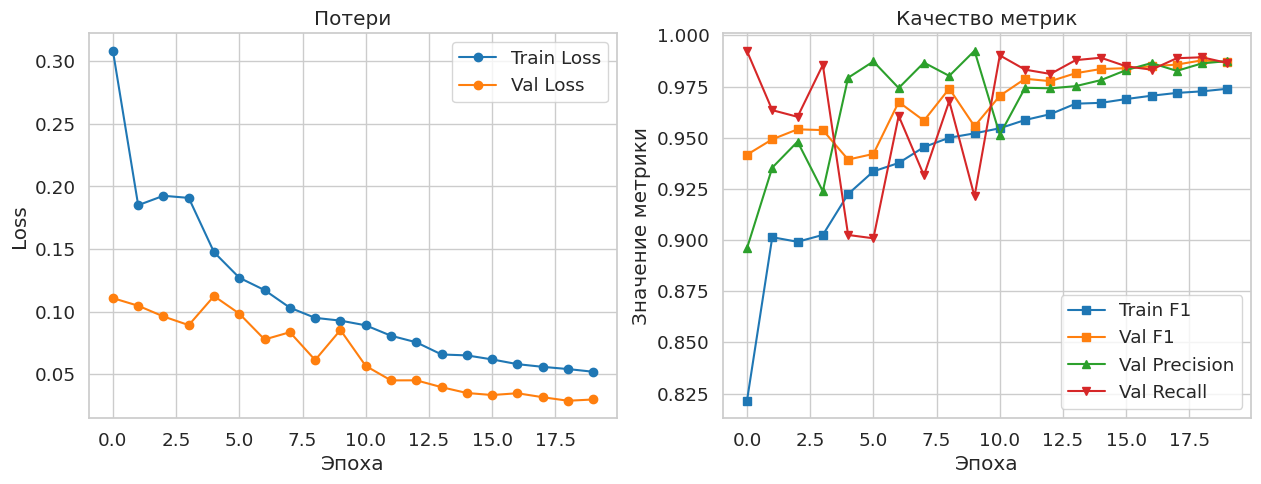

In [10]:
plot_training_history(history)

### Финальная оценка

BEST MODEL:


Тестирование: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]

Финальные метрики качества:
Accuracy: 0.9877
Precision: 0.9863
Recall: 0.9893
F1-Score: 0.9878


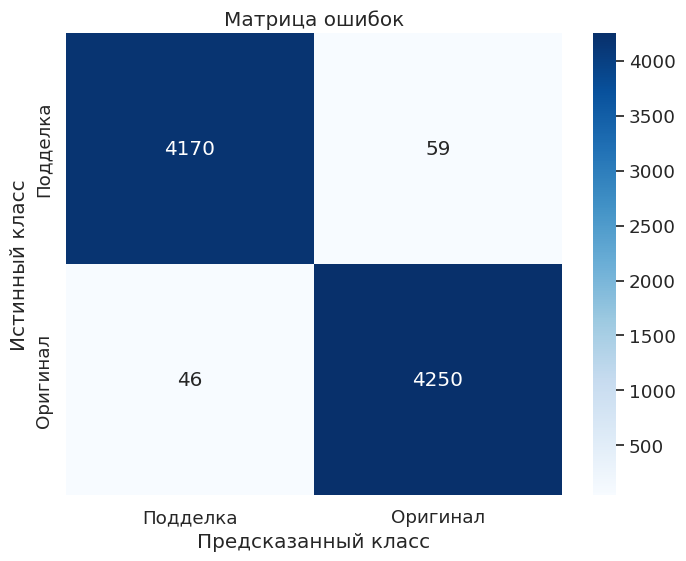


FINAL MODEL:


Тестирование: 100%|██████████| 34/34 [00:37<00:00,  1.12s/it]

Финальные метрики качества:
Accuracy: 0.9869
Precision: 0.9874
Recall: 0.9865
F1-Score: 0.9870


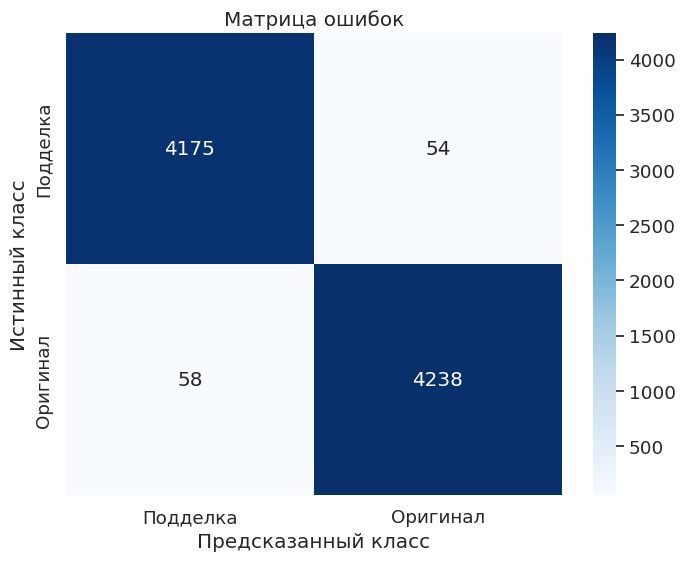

In [11]:
model = SiameseViT(**model_params).to(device)
model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
print("BEST MODEL:")
evaluate_model(model, test_loader, device)

model = SiameseViT(**model_params).to(device)
model.load_state_dict(torch.load(final_model_path)['model_state_dict'])
print("\nFINAL MODEL:")
evaluate_model(model, test_loader, device)